In [12]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Flatten, MaxPooling1D, BatchNormalization, MultiHeadAttention, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import mediapipe as mp
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pickle
import tensorflow as tf

In [4]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1733711727.469825     128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733711727.528175     128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [13]:
def extract_skeleton_features(video_path):
    cap = cv2.VideoCapture(video_path)
    frames_landmarks = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        # Chuyển đổi BGR sang RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Phát hiện pose
        results = pose.process(frame_rgb)
        
        if results.pose_landmarks:
            # Lấy các điểm landmark (33 điểm, mỗi điểm có x,y,z)
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark])
            frames_landmarks.append(landmarks.flatten())
    
    cap.release()
    
    # Chuẩn hóa số frame về cùng một độ dài
    if len(frames_landmarks) > 0:
        frames_landmarks = np.array(frames_landmarks)
        # Lấy 30 frame đều nhau từ video
        target_frames = 30
        if len(frames_landmarks) >= target_frames:
            indices = np.linspace(0, len(frames_landmarks)-1, target_frames, dtype=int)
            frames_landmarks = frames_landmarks[indices]
        else:
            # Padding nếu video quá ngắn
            padding = np.zeros((target_frames - len(frames_landmarks), frames_landmarks.shape[1]))
            frames_landmarks = np.vstack((frames_landmarks, padding))
        
        return frames_landmarks
    return None

def load_dataset(data_path):
    X = []
    y = []
    
    # Lặp qua các thư mục class
    classes = sorted(os.listdir(data_path))
    print("Loading dataset...")
    
    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        # Lặp qua các video trong class
        for video_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            video_path = os.path.join(class_path, video_name)
            
            # Trích xuất đặc trưng skeleton
            features = extract_skeleton_features(video_path)
            
            if features is not None:
                X.append(features)
                y.append(class_name)
    
    X = np.array(X)
    y = np.array(y)
    
    # Encode nhãn
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = to_categorical(y)
    
    return X, y, le

def build_cnn_model(input_shape, num_classes):
    """
    Mô hình CNN đơn giản.
    """
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
    

def build_resnet_1d_model(input_shape, num_classes):
    """
    Mô hình ResNet đơn giản cho dữ liệu 1D.
    """
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_CNN_LSTM_model(input_shape, num_classes):  
    """
    Xây dựng mô hình CNN-LSTM
    """
    model = Sequential([
        # CNN layers
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        
        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        
        # LSTM layers
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        
        LSTM(64),
        Dropout(0.3),
        
        # Dense layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_transformer_model(input_shape, num_classes):

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Multi-Head Attention Block
    for _ in range(2):
        attn_output = MultiHeadAttention(num_heads=8, key_dim=128)(inputs, inputs)
        attn_output = LayerNormalization(epsilon=1e-6)(attn_output)  # Normalization

    # Adding Dense layers after attention
    x = Flatten()(attn_output)  # Flattening the attention outputs
    x = Dense(128, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.3)(x)  # Regularization

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Model definition
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
    
def plot_training_history(history):
    """
    Vẽ đồ thị accuracy và loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])
    
    plt.show()

def plot_confusion_matrix(y_true, y_pred, label_encoder):
    """
    Vẽ confusion matrix
    """
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def save_model(model, model_path, label_encoder, label_encoder_path):
    """
    Lưu model và label encoder
    """
    # Lưu model
    model.save(model_path)
    
    # Lưu label encoder
    with open(label_encoder_path, 'wb') as f:
        pickle.dump(label_encoder, f)
    
    print(f"Đã lưu model tại: {model_path}")
    print(f"Đã lưu label encoder tại: {label_encoder_path}")

In [6]:
data_path = '/kaggle/input/dataset'

In [7]:
X, y, label_encoder = load_dataset(data_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

Loading dataset...


Processing stand_up: 100%|██████████| 100/100 [03:33<00:00,  2.13s/it]


In [24]:
# model = build_cnn_model(input_shape, num_classes)
# model = build_resnet_1d_model(input_shape, num_classes)
# model = build_CNN_LSTM_model(input_shape, num_classes)
# model = build_transformer_model(input_shape, num_classes)

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.4269 - loss: 1.7812 - val_accuracy: 0.2071 - val_loss: 1.8483
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8372 - loss: 0.5022 - val_accuracy: 0.4000 - val_loss: 1.7730
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9099 - loss: 0.2573 - val_accuracy: 0.4357 - val_loss: 1.6673
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9354 - loss: 0.2021 - val_accuracy: 0.3357 - val_loss: 1.5963
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9666 - loss: 0.1336 - val_accuracy: 0.4714 - val_loss: 1.5504
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9633 - loss: 0.1190 - val_accuracy: 0.3929 - val_loss: 1.5871
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9734 - loss: 0.1083 - val_accuracy: 0.4214 - val_loss: 1.5879
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9765 - loss: 0.0765 - val_accuracy: 0.3857 - val_loss: 1.5588


In [25]:
callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Training model...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9869 - loss: 0.0424 - val_accuracy: 0.6071 - val_loss: 1.2107
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9955 - loss: 0.0406 - val_accuracy: 0.7857 - val_loss: 0.5897
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9858 - loss: 0.0332 - val_accuracy: 0.8214 - val_loss: 0.5145
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9966 - loss: 0.0198 - val_accuracy: 0.7429 - val_loss: 0.7530
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9916 - loss: 0.0226 - val_accuracy: 0.7071 - val_loss: 0.9294
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9932 - loss: 0.0217 - val_accuracy: 0.7857 - val_loss: 0.5860
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9848 - loss: 0.0389 - val_accuracy: 0.8214 - val_loss: 0.6296
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9680 - loss: 0.0886 - val_accuracy:

## Simple CNN


Evaluating model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8219 - loss: 0.5628 

Test accuracy: 0.8643
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Classification Report:
              precision    recall  f1-score   support

falling_down       0.96      1.00      0.98        25
     jump_up       0.76      1.00      0.86        22
     kicking       0.73      0.76      0.74        21
       punch       0.74      0.70      0.72        20
     running       1.00      0.71      0.83        14
    sit_down       1.00      0.78      0.88        18
    stand_up       1.00      1.00      1.00        20

    accuracy                           0.86       140
   macro avg       0.88      0.85      0.86       140
weighted avg       0.88      0.86      0.86       140



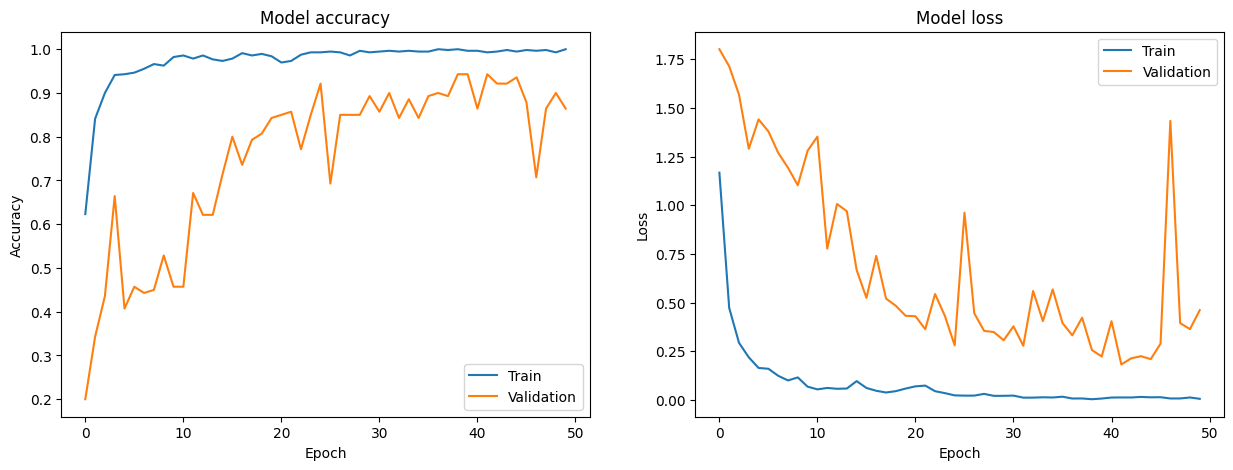

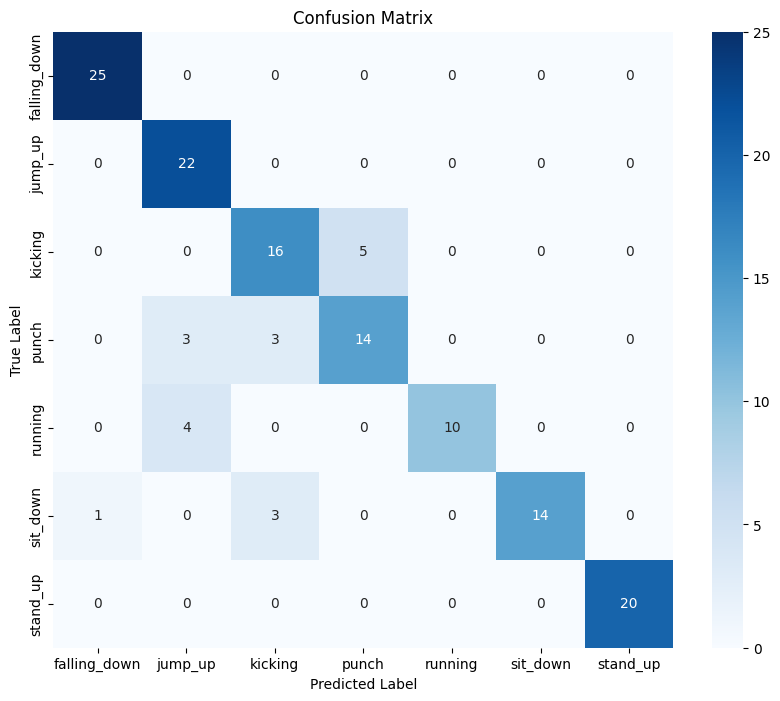

In [18]:
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)

# In classification report
print("\nClassification Report:")
print(classification_report(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    target_names=label_encoder.classes_
))

plot_training_history(history)
plot_confusion_matrix(y_test, y_pred, label_encoder)

## ResNet-1D

In [26]:
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)

# In classification report
print("\nClassification Report:")
print(classification_report(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    target_names=label_encoder.classes_
))


Evaluating model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8124 - loss: 0.5508 

Test accuracy: 0.8214
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step

Classification Report:
              precision    recall  f1-score   support

falling_down       1.00      0.76      0.86        25
     jump_up       1.00      0.95      0.98        22
     kicking       0.70      0.90      0.79        21
       punch       0.58      0.75      0.65        20
     running       1.00      0.43      0.60        14
    sit_down       0.73      0.89      0.80        18
    stand_up       1.00      0.95      0.97        20

    accuracy                           0.82       140
   macro avg       0.86      0.81      0.81       140
weighted avg       0.86      0.82      0.82       140



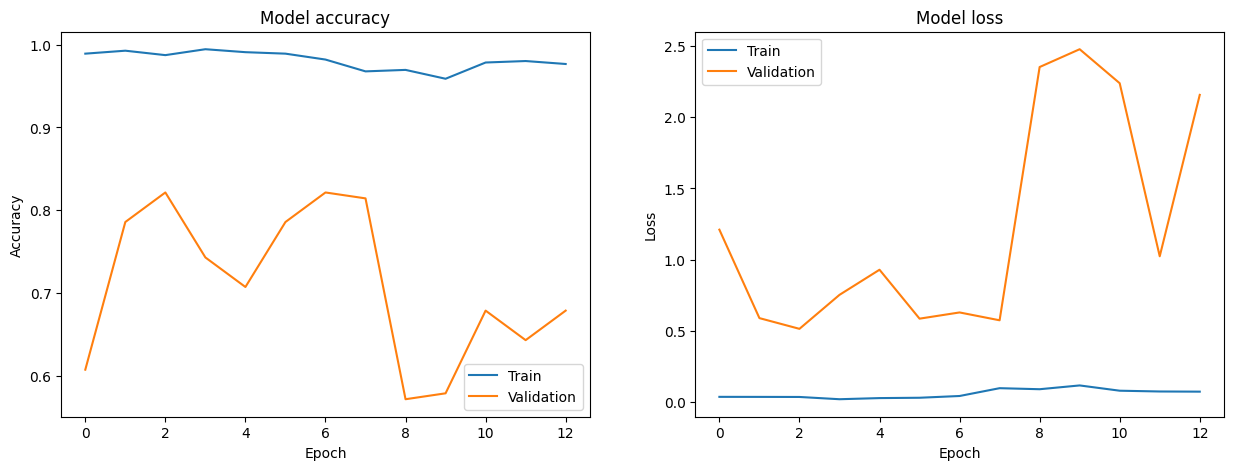

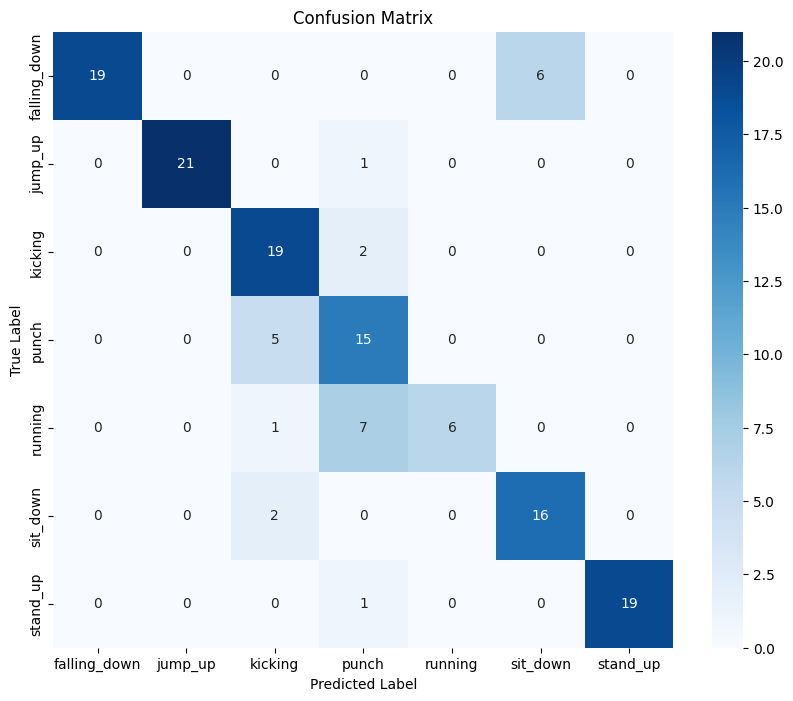

Đã lưu model tại: resnet_action_recognition_model.keras
Đã lưu label encoder tại: label_encoder.pkl


In [28]:
plot_training_history(history)
plot_confusion_matrix(y_test, y_pred, label_encoder)

## Transformer 


Evaluating model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0924 - loss: 1.9502 

Test accuracy: 0.1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step

Classification Report:
              precision    recall  f1-score   support

falling_down       0.00      0.00      0.00        25
     jump_up       0.00      0.00      0.00        22
     kicking       0.00      0.00      0.00        21
       punch       0.00      0.00      0.00        20
     running       0.10      1.00      0.18        14
    sit_down       0.00      0.00      0.00        18
    stand_up       0.00      0.00      0.00        20

    accuracy                           0.10       140
   macro avg       0.01      0.14      0.03       140
weighted avg       0.01      0.10      0.02       140



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


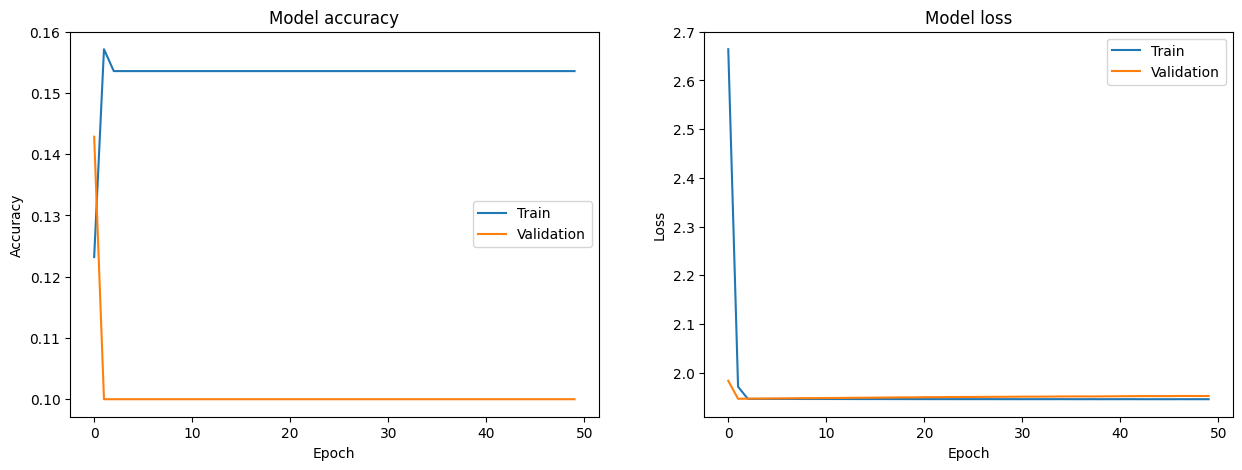

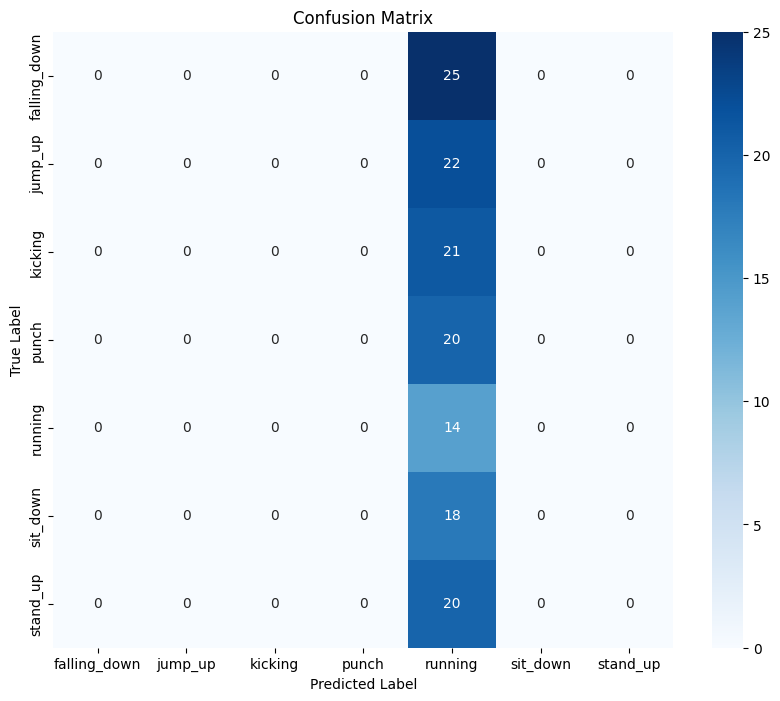

In [29]:
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)

# In classification report
print("\nClassification Report:")
print(classification_report(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    target_names=label_encoder.classes_
))

plot_training_history(history)
plot_confusion_matrix(y_test, y_pred, label_encoder)